In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import yaml
plt.style.use("../science.mplstyle")

from helpers.plotting import feature_labels, feature_bins
from helpers.physics_functions import bkg_fit_cubic, bkg_fit_quintic, bkg_fit_septic, get_bins, curve_fit_m_inv, calculate_test_statistic

In [2]:
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)
    
project_id = "lowmass"
particle_type = "upsilon"
data_id = "skimmed_data_2016H_30555"


path_to_data_dir = workflow["file_paths"]["data_storage_dir"]
path_to_data = f"{path_to_data_dir}/compiled_data/{project_id}"

with open(f"{path_to_data}/{data_id}_nojet", "rb") as input_file:
        all_data = pickle.load(input_file)


In [3]:
SB_left = float(workflow["window_definitions"][particle_type]["SB_left"])
SR_left = float(workflow["window_definitions"][particle_type]["SR_left"])
SR_right = float(workflow["window_definitions"][particle_type]["SR_right"])
SB_right = float(workflow["window_definitions"][particle_type]["SB_right"])

bkg_fit_type = "quintic"
num_bins_SR = 12
bkg_fit_function = bkg_fit_quintic
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR= num_bins_SR)
x = np.linspace(SB_left, SB_right, 100) 
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR= num_bins_SR)

print(SB_left, SB_right)

7.8 15.0


# Triggering studies

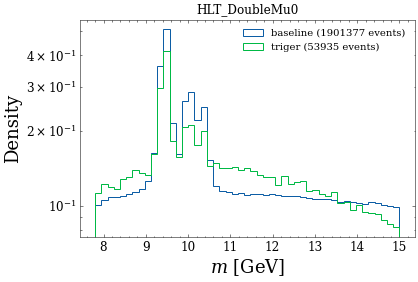

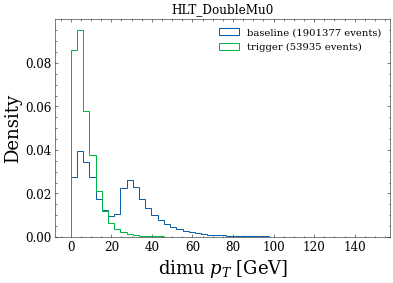

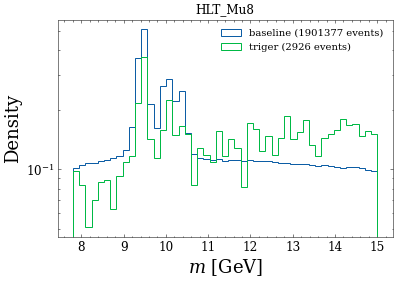

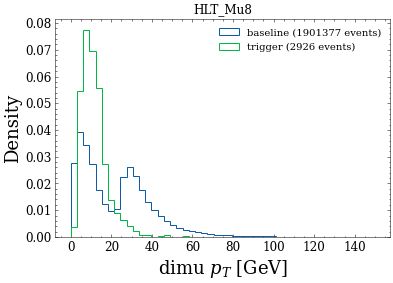

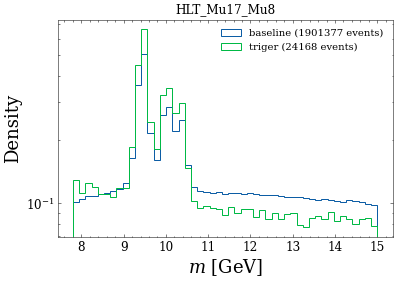

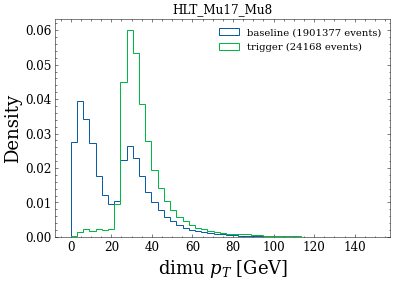

In [4]:

in_SB = (all_data["dimu_mass"] >= SB_left) & (all_data["dimu_mass"] <= SB_right)# & (all_data["mu0_iso04"] >= 0.55) & (all_data["mu1_iso04"] >= 0.55)


for trig in ["HLT_DoubleMu0", "HLT_Mu8", "HLT_Mu17_Mu8"]:
    
    
    events_all = all_data["dimu_mass"][in_SB]
    events_trig = all_data["dimu_mass"][in_SB][all_data[trig][in_SB]]
    bins = np.linspace(SB_left, SB_right, 50)
    plt.figure()
    plt.hist(events_all, bins = bins, label = f"baseline ({len(events_all)} events)", histtype = "step", density = True)
    plt.hist(events_trig, bins = bins, label = f"triger ({len(events_trig)} events)", histtype = "step", density = True)
    #plt.xscale("log")
    plt.yscale("log")
    plt.ylabel("Density")
    plt.legend()
    plt.xlabel("$m$ [GeV]")
    plt.title(trig)
    plt.show()
    
    
    events_all = all_data["dimu_pt"][in_SB]
    events_trig = all_data["dimu_pt"][in_SB][all_data[trig][in_SB]]
    bins = np.linspace(0, 150, 50)
    plt.figure()
    plt.hist(events_all, bins = bins, label = f"baseline ({len(events_all)} events)", histtype = "step", density = True)
    plt.hist(events_trig, bins = bins, label = f"trigger ({len(events_trig)} events)", histtype = "step", density = True)
    #plt.yscale("log")
    plt.ylabel("Density")
    plt.legend()
    plt.xlabel("dimu $p_T$ [GeV]")
    plt.title(trig)
    plt.show()

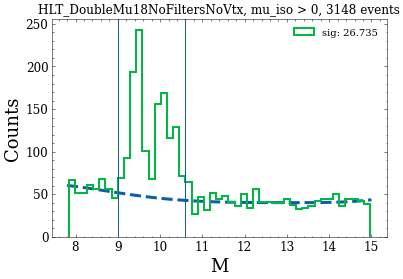

In [5]:
iso_cut = 0
trig = "HLT_DoubleMu18NoFiltersNoVtx"
in_SB = (all_data["dimu_mass"] >= SB_left) & (all_data["dimu_mass"] <= SB_right) & (all_data["mu0_iso04"] >= 0) & (all_data["mu1_iso04"] >= iso_cut)

masses = all_data["dimu_mass"][in_SB][all_data[trig][in_SB]]
#masses = np.random.choice(masses, size = 20000)

popt_0, pcov, _, _, _ = curve_fit_m_inv(masses, bkg_fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)

plt.figure()
plt.plot(x, bkg_fit_function(x, *popt_0), lw = 3, linestyle = "dashed")
sig = np.sqrt(calculate_test_statistic(masses, bkg_fit_function, bkg_fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt_0, pcov))
plt.hist(masses, bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = f"sig: {round(sig,3)}")
plt.legend()
plt.title(f"{trig}, mu_iso > {iso_cut}, {len(masses)} events")
plt.axvline(SR_right)
plt.axvline(SR_left)
plt.xlabel("M")
plt.ylabel("Counts")
plt.show()

# Various kinematic observables

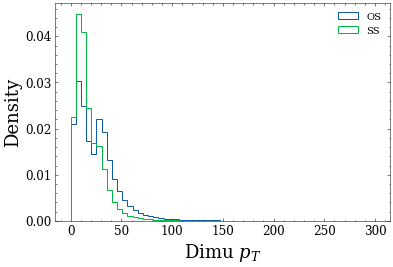

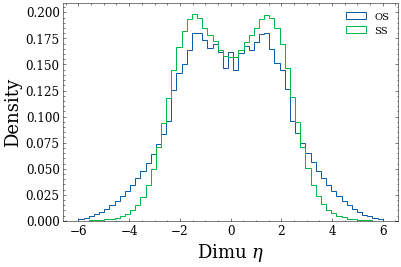

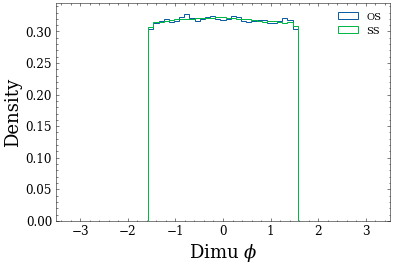

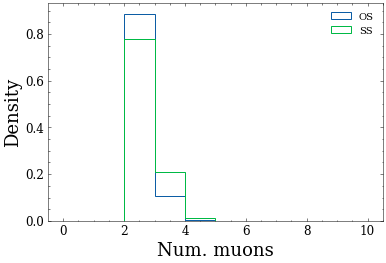

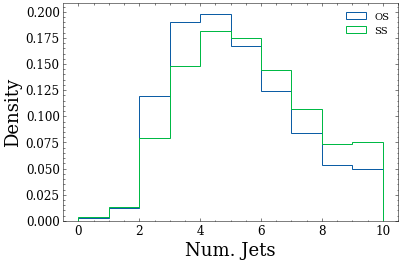

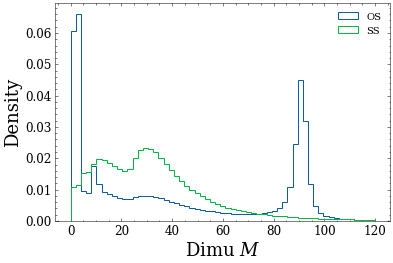

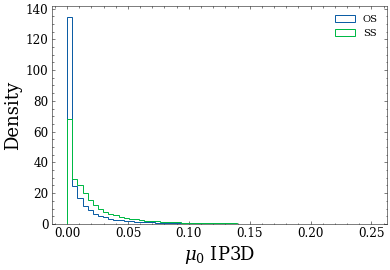

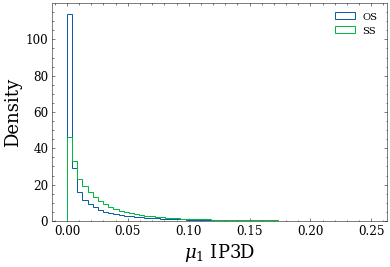

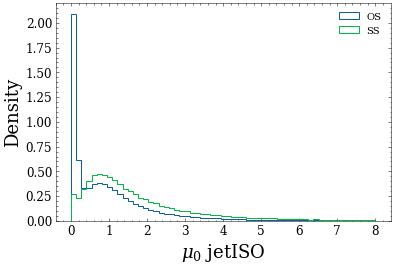

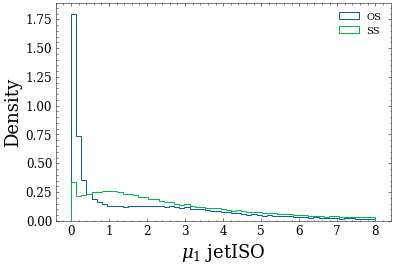

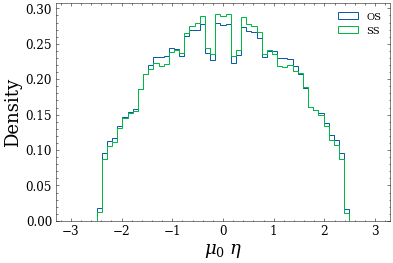

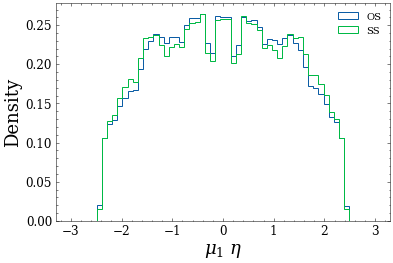

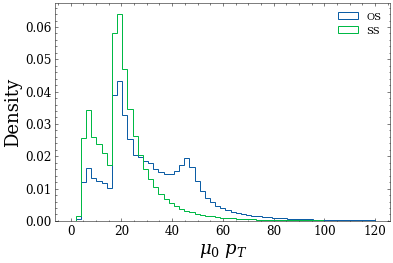

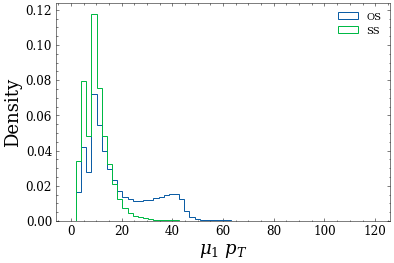

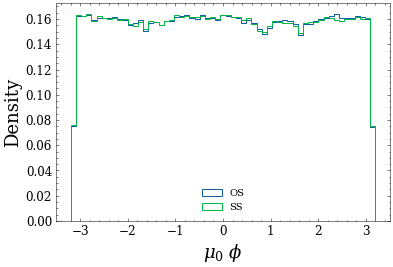

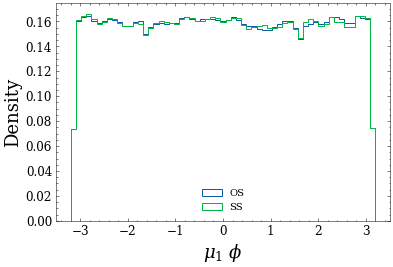

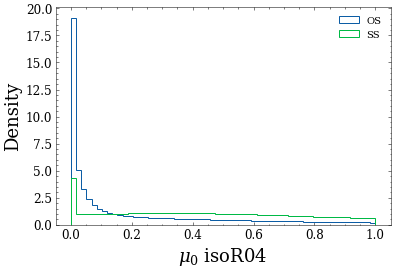

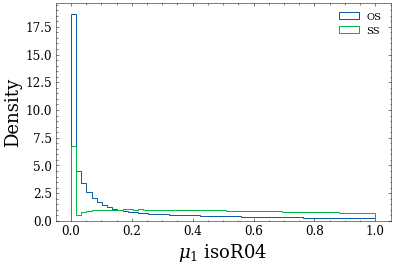

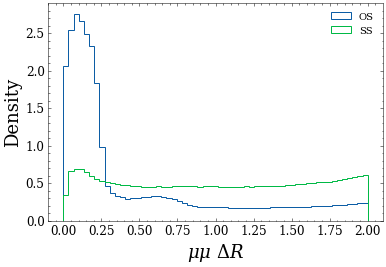

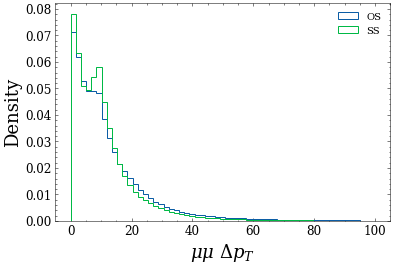

In [12]:
vars_to_plot = all_data.keys()

for var in vars_to_plot:
    
    if ("samesign" not in var) and ("HLT" not in var):
    
        plt.figure()
        plt.hist(all_data[var], bins = feature_bins[var], histtype = "step", density = True, label = "OS")
        plt.hist(all_data[var+"_samesign"], bins = feature_bins[var], histtype = "step", density = True, label = "SS")
        plt.xlabel(feature_labels[var])
        plt.ylabel("Density")
        plt.legend()
        plt.show()


Look at the samesign dimuon mass spectrum

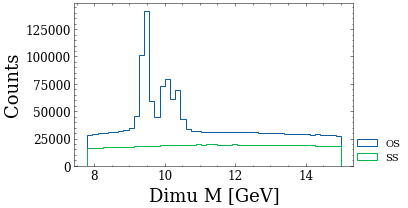

In [16]:



plt.figure(figsize = (5,3))

plt.hist(all_data["dimu_mass"], bins = np.linspace(SB_left, SB_right, 50), histtype = "step", label = f"OS")
plt.hist(all_data["dimu_mass_samesign"], bins = np.linspace(SB_left, SB_right, 50), histtype = "step", label = f"SS")


plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0))
plt.show()



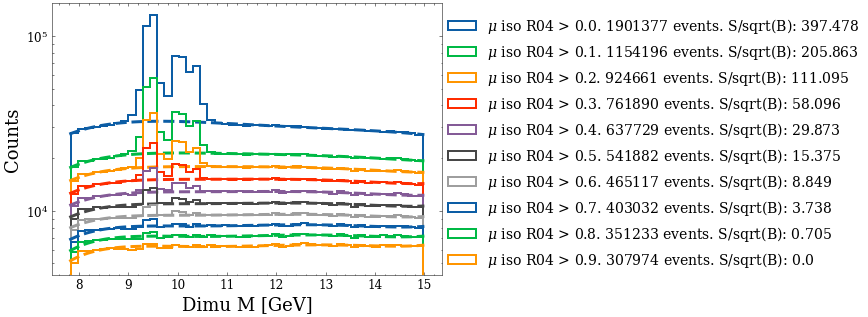

In [27]:
muon_iso_cuts = np.arange(0, 1, 0.1) # anti-isolation cut -- want muon iso to be ABOVE this, which means more junk
dimuon_pt_cuts = np.arange(50, 150, 10)

isoc = 0
ptc = 0

cut_pt = False


plt.figure(figsize = (7,5))
    

filters, labels = [], []

if cut_pt:
    for ptc in dimuon_pt_cuts: 
        loc_filter = (all_data["mu0_iso04"]>=isoc) & (all_data["mu1_iso04"]>=isoc)  &(all_data["dimu_pt"]>=ptc) 
        filters.append(loc_filter)
        labels.append(f"$\mu\mu$ $p_T$ > {round(ptc, 2)} GeV")

else:
    for isoc in muon_iso_cuts: 
        loc_filter = (all_data["mu0_iso04"]>=isoc) & (all_data["mu1_iso04"]>=isoc)   &(all_data["dimu_pt"]>=ptc) 
        filters.append(loc_filter)
        labels.append(f"$\mu$ iso R04 > {round(isoc, 2)}")

for i in range(len(filters)):
    
    loc_data = all_data["dimu_mass"][filters[i]]
    N_events = len(loc_data[(loc_data >= SB_left) & (loc_data <= SB_right)])

    popt_0, pcov, _, _, _ = curve_fit_m_inv(loc_data, bkg_fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
    sig = np.sqrt(calculate_test_statistic(loc_data, bkg_fit_function, bkg_fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt_0, pcov))
    plt.hist(loc_data, bins = plot_bins_all, lw = 2, color = f"C{i}", histtype = "step", density = False, label = labels[i]+f". {N_events} events. S/sqrt(B): {round(sig,3)}")
    plt.plot(x, bkg_fit_function(x, *popt_0), lw = 3, color = f"C{i}", linestyle = "dashed")

plt.yscale("log")
plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0), fontsize = 14)
plt.show()

